## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
hallo = tf.constant('why?' )
print(hallo)

tf.Tensor(b'why?', shape=(), dtype=string)


## 데이터 디렉터리 구조

In [3]:
import pathlib
dataset_url = "./data/train"
data_dir = pathlib.Path(dataset_url)

## 파라미터 정의


In [4]:
batch_size = 32
img_height = 768
img_width = 768

#### training data : 80%

In [5]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, #".\\data\\train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1198 files belonging to 2 classes.
Using 959 files for training.


#### validation data : 20%

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1198 files belonging to 2 classes.
Using 239 files for validation.


#### 레이블 확인 

In [7]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'STENOSIS']


## 데이터 확인
일부 트레이닝 데이터의 시각적 확인

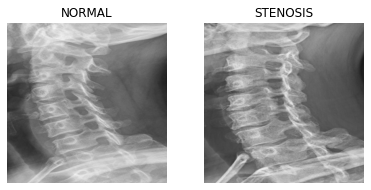

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
  print("Batch, SizeW, SizeH, RGB",image_batch.shape)
  print("Image Label",labels_batch.shape)
  break

Batch, SizeW, SizeH, RGB (2, 768, 768, 3)
Image Label (2,)


In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 정규화

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.04540955 1.0


# 모델 구성

### Augmentation

In [13]:
import random
import tensorflow.keras.backend as K
class dataShuffler(tf.keras.layers.Layer):
    def __init__(self, patch_size, input_size):
        super(dataShuffler,self).__init__()
        self.patch_size = patch_size
        self.input_size = input_size
    def call(self, inputs):
        output =  []
        for i in range(len(inputs)):
            input_img = K.eval(inputs[i])
            input_img = np.array(inputs[i])
            output_image = np.random.rand(self.input_size , self.input_size , 3 )
            patches = []
            #print(self.input_size)
            for j in range( 0 , self.input_size , self.patch_size ):
                for k in range( 0 , self.input_size , self.patch_size ):
                    patches.append( input_img[j : j + self.patch_size , k : k + self.patch_size , : ] )
            random.shuffle(patches)
            count = 0
            for j in range( 0 , self.input_size , self.patch_size ):
                for k in range( 0 , self.input_size , self.patch_size ):
                    output_image[j : j + self.patch_size , k : k + self.patch_size ,:] = patches[count]
                    count+=1
            output.append(output_image)
        return K.constant(output)

In [14]:
data_augmentation = keras.Sequential(
  [
    dataShuffler(256,768),
  ]
)

#### Augmentation Result

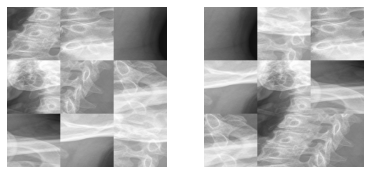

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(batch_size):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

In [16]:
num_classes=5
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 컴파일

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              run_eagerly=True)

In [18]:
epochs = 1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

480/480 [==============================] - 1111s 2s/step - loss: 0.5243 - accuracy: 0.5833 - val_loss: 0.6540 - val_accuracy: 0.6227


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  0         
                                                                 
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 conv2d (Conv2D)             multiple                  448       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                  